In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import akantu as aka
import numpy as np
import matplotlib.pyplot as plt

from contact_mechanics_internodes import ContactMechanicsInternodes
from helper import plot_mesh

In [2]:
mesh_file = 'mesh/contact2d_circle.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.1, aka._y), 'secondary_fixed')

# Get positions of all nodes, surface connectivity and candidate nodes
positions = mesh.getNodes()
surface_connectivity = mesh.getConnectivity(aka._segment_2)
nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()

# Set initial conditions
internodes_model = ContactMechanicsInternodes(spatial_dimension, model, positions, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary)

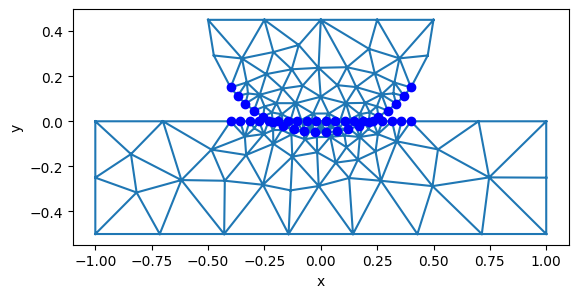

----> Starting iteration 1 <----
Interpenetrating nodes:  []
Nodes in tension:  [ 3  4  8  9 19 36 41 42 57 58]


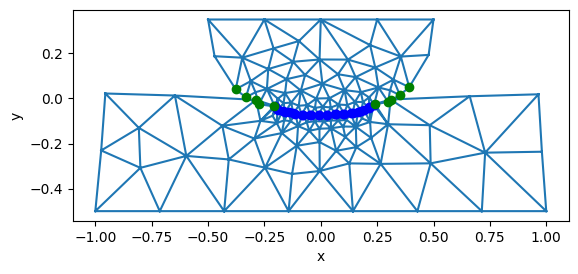

----> Starting iteration 2 <----
Interpenetrating nodes:  []
Nodes in tension:  [20 35 43]


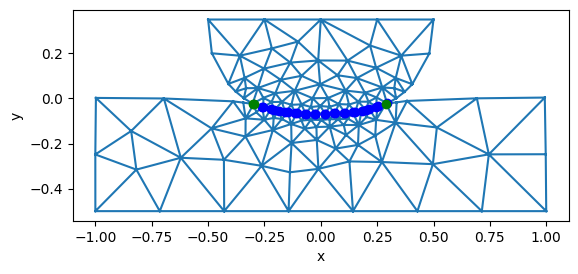

----> Starting iteration 3 <----
Interpenetrating nodes:  []
Nodes in tension:  []


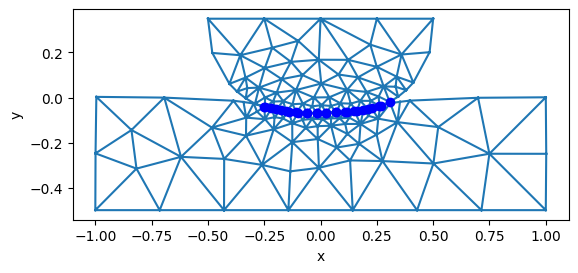


successfully converged in 3 iterations


In [3]:
# Plot initial configuration
nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
plot_mesh(internodes_model.nodal_positions, mesh.getConnectivity(aka._triangle_3), nodes_interface)

max_iter = 10
for i in range(max_iter):
    print("----> Starting iteration", i+1, "<----")

    nodes_interface_primary_old = internodes_model.nodes_interface_primary
    nodes_interface_secondary_old = internodes_model.nodes_interface_secondary

    # Find the interface nodes
    internodes_model.find_interface_nodes()

    # Assemble model
    internodes_model.assemble_full_model()

    # Solve model
    displacements, lambdas = internodes_model.solve_direct()

    # Update the interface nodes and check if it converged
    converged = internodes_model.update_interface(displacements, lambdas)

    nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
    nodes_interpenetrating = np.union1d(
        np.setdiff1d(internodes_model.nodes_interface_primary, nodes_interface_primary_old),
        np.setdiff1d(internodes_model.nodes_interface_secondary, nodes_interface_secondary_old))
    nodes_tension = np.union1d(
        np.setdiff1d(nodes_interface_primary_old, internodes_model.nodes_interface_primary),
        np.setdiff1d(nodes_interface_secondary_old, internodes_model.nodes_interface_secondary))
    print("Interpenetrating nodes: ", nodes_interpenetrating)
    print("Nodes in tension: ", nodes_tension)

    # Plot the obtained solution
    positions_new = internodes_model.nodal_positions + displacements
    plot_mesh(positions_new, mesh.getConnectivity(aka._triangle_3), nodes_interface, nodes_interpenetrating, nodes_tension)

    if converged:
        print('\nsuccessfully converged in', i+1, 'iterations')
        break